# Download Data

In [ ]:
! wget https://cloudstor.aarnet.edu.au/plus/s/sXfWoQZ2CFbPzo0/download?path=%2F&files=annotatedLibrary.zip

In [ ]:
! unzip /content/download?path=%2F
! rm /content/download?path=%2F

In [ ]:
! mv /content/annotatedLibrary/annotatedLibrary.zip .
! rm -r /content/annotatedLibrary/

In [ ]:
! unzip /content/annotatedLibrary.zip
! rm /content/annotatedLibrary.zip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mv /content/annotatedLibrary /content/drive/MyDrive/Projects/Data

# Prepare data

In [9]:
### Load necessary libraries ###
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [10]:
import numpy as np
np.load.__defaults__=(None, False, True, 'ASCII')
np_load_old = np.load
loadnpz = lambda *a,**k: np_load_old(*a,allow_pickle=True)

In [11]:
### Define helper functions ###
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp, sr=250)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(15,6))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(15,6))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(len(sound_names),1,i)
        specgram(np.array(f), Fs=250)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(15,6))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

In [12]:
class Path:
    def __init__(self, parent):
        self.working_folder = parent

    def get(self, sub):
        sub_f = os.path.join(self.working_folder, sub)
        if os.path.exists(sub_f):
            return sub_f
        raise Exception(f"No such folder or file with the name {sub} in {self.working_folder}")

    def endswith(self, folder, suff):
        subfolder = self.get(folder)
        subdirs = os.listdir(subfolder)
        files = []      
        for sub in subdirs:
            sub_f = os.path.join(subfolder, sub)
            if sub_f.endswith(suff) and os.path.isfile(sub_f):
                files.append(sub_f)
        return files

In [13]:
work = Path('/content/drive/MyDrive/Projects/Data/annotatedLibrary')

folders = [
    'BallenyIslands2015',
    'ElephantIsland2013Aural',
    'ElephantIsland2014',
    'Greenwich64S2015',
    'MaudRise2014',
    'RossSea2014',
    'casey2014',
    'casey2017',
    'kerguelen2005',
    'kerguelen2014',
    'kerguelen2015'
]

save_dir = 'processed/third'

## Data augmentation

In [24]:
def augment_noise(wav):
    wav = wav + 0.009 * np.random.normal(0,1,len(wav))
    return wav

def augment_time(wav, factor=.4):
    wav = librosa.effects.time_stretch(wav, factor)
    return wav

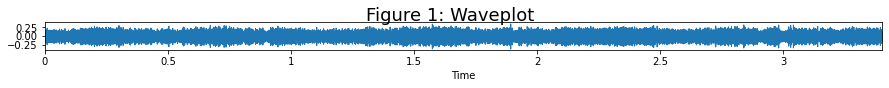

In [22]:
wav = load_sound_files(['/content/drive/MyDrive/Projects/Data/annotatedLibrary/ElephantIsland2013Aural/wav/20130112_130000_AWI251-01_AU0231_250Hz.wav'])[0]
plot_waves([""], [wav])

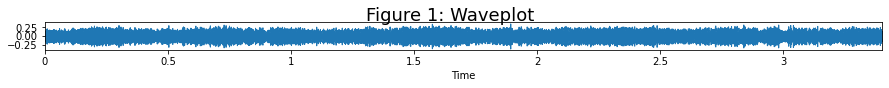

In [25]:
wav1 = augment_noise(wav)
plot_waves([""], [wav1])

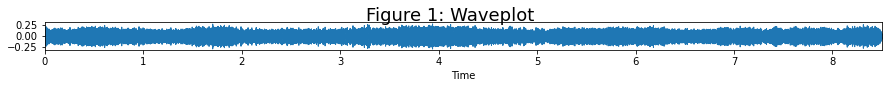

In [26]:
wav2 = augment_time(wav)
plot_waves([""], [wav2])

## Features Extraction

In [5]:
def parse_audio_files(dir,file_ext='*.wav'):
    print(f'Parsing: {dir}')
    meta = os.path.join(dir, 'meta.xlsx')
    wavf = os.path.join(dir, 'wav/')

    df = pd.read_excel(meta, engine='openpyxl')
    df = df[:100]
    files = list(df['wavFileName'])[:100]
    df = df[['Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'BlueFM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_calls', 'Unidentified']]

    df = df.fillna(0)
    df['Bm Ant-A'] = df['Bm Ant-A'].astype(float) 
    df['Bm Ant-B'] = df['Bm Ant-B'].astype(float) 
    df['Bm Ant-Z'] = df['Bm Ant-Z'].astype(float) 
    df['BlueFM'] = df['BlueFM'].astype(float) 
    df['Bp Downsweep'] = df['Bp Downsweep'].astype(float) 
    df['Bp 20Hz'] = df['Bp 20Hz'].astype(float) 
    df['Bp Higher_calls'] = df['Bp Higher_calls'].astype(float) 
    df['Unidentified'] = df['Unidentified'].astype(float)

    train_data = []
    for f in tqdm(files):
        if (f.endswith('.wav') or f.endswith('.WAV')):
            f = os.path.join(wavf, f)
        else:
            f = os.path.join(wavf, f+'.wav')
        if os.path.isfile(f):
            y, sr = librosa.load(f, sr=250)
            # get the magnitudes
            D = np.abs(librosa.stft(y, n_fft=512))  # use 4096 as window length
            data = librosa.feature.melspectrogram(S=D, n_fft=512, hop_length=256)
            train_data.append(data)
        else:
            raise Exception("Couldn't find: ", f)
    df = df.assign(Data=train_data)
    
    new_order = [8,0,1,2,3,4,5,6,7]
    df = df[df.columns[new_order]]

    df['Label'] = df[['Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'BlueFM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_calls', 'Unidentified']].values.tolist()
    
    return df['Data'].to_numpy(), df['Label'].to_numpy()

In [9]:
for sub_dir in folders:
    features, labels = parse_audio_files(work.get(sub_dir))
    np.savez(work.get(save_dir)+'/'+sub_dir, features=features, labels=labels)

Parsing: /content/drive/MyDrive/Projects/Data/annotatedLibrary/BallenyIslands2015


100%|██████████| 100/100 [06:19<00:00,  3.80s/it]


Parsing: /content/drive/MyDrive/Projects/Data/annotatedLibrary/ElephantIsland2013Aural


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


## Preparing data for the model

In [22]:
features = []
labels = []
for sub in folders:
    print(sub)
    x = loadnpz(work.get(save_dir)+'/'+sub+'.npz')
    t = x['features']
    for i in range(len(t)):
        pl = 7033 - t[i].shape[1]
        # pad short arrays with zeros
        tl = np.pad(t[i], ((0,0), (0,pl)), constant_values=(0))
        features.append(tl.reshape((1,*tl.shape)))
        labels.append(np.array(x['labels'][i]))

BallenyIslands2015
ElephantIsland2013Aural
ElephantIsland2014
Greenwich64S2015
MaudRise2014
RossSea2014
casey2014
casey2017
kerguelen2005
kerguelen2014
kerguelen2015


In [23]:
features = np.stack(features)
labels = np.stack(labels)

(features.shape, labels.shape)

((1100, 1, 128, 7033), (1100, 8))

In [24]:
class WhaleData(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels   = labels

    def __len__(self):
        assert len(self.features) == len(self.labels), "Fetaures length doesn't match labels length"
        return len(self.features)

    def __getitem__(self, idx):
        spec_tensor = torch.tensor(self.features[idx])
        spec_label = torch.tensor(self.labels[idx])
        return spec_tensor, spec_label

In [25]:
dataset = WhaleData(features, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=10)

# Model Training

### DenseNet
### Inception

In [26]:
classes = ['Bm Ant-A', 'Bm Ant-B', 'Bm Ant-Z', 'BlueFM', 'Bp Downsweep', 'Bp 20Hz', 'Bp Higher_calls', 'Unidentified']
num_epochs = 100

model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(
    1,
    model.conv1.out_channels,
    kernel_size=model.conv1.kernel_size[0],
    stride=model.conv1.stride[0],
    padding=model.conv1.padding[0]
)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.25), 
    nn.Linear(num_ftrs, len(classes)), 
    nn.Sigmoid()
)
model = model.float()

In [27]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=.1)
criterion = nn.BCEWithLogitsLoss()

In [34]:
device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
model.to(device); # remoe ';' to print model architecture

Device:  0


In [39]:
def train(model, epoch):
    model.train()

    for idx, (data, label) in enumerate(train_loader):
        inputs = data.to(device) 
        label = label.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        if idx % 10 == 9:
            print(f'Train Epoch {epoch} : Iteration {idx}/{len(train_loader)} : Loss {loss.item()}')

In [42]:
for e in range(2):
    train(model, e)
    scheduler.step()

Train Epoch 0 : Iteration 9/88 : Loss 0.66671014952517
Train Epoch 0 : Iteration 19/88 : Loss 0.7018118136697012
Train Epoch 0 : Iteration 29/88 : Loss 0.6398916253161588
Train Epoch 0 : Iteration 39/88 : Loss 0.7319720721920021
Train Epoch 0 : Iteration 49/88 : Loss 0.6958438981269865
Train Epoch 0 : Iteration 59/88 : Loss 0.6757784605583765
Train Epoch 0 : Iteration 69/88 : Loss 0.7004377240649774
Train Epoch 0 : Iteration 79/88 : Loss 0.6560297466456178
Train Epoch 1 : Iteration 9/88 : Loss 0.632531382030993
Train Epoch 1 : Iteration 19/88 : Loss 0.6943271780188298
Train Epoch 1 : Iteration 29/88 : Loss 0.6720672403171193
Train Epoch 1 : Iteration 39/88 : Loss 0.6870492106289021
Train Epoch 1 : Iteration 49/88 : Loss 0.7112032454113433
Train Epoch 1 : Iteration 59/88 : Loss 0.6818929087607103
Train Epoch 1 : Iteration 69/88 : Loss 0.6711546786420514
Train Epoch 1 : Iteration 79/88 : Loss 0.6761590654110479


In [43]:
s = 0
for idx, (data, label) in enumerate(test_loader):
    inputs = data.to(device) 
    labels = label

    outputs = model(inputs).detach().cpu()
    
    outputs[outputs > .85] = 1
    outputs[np.where(np.logical_and(outputs > .65, outputs <= .85))] = .75
    outputs[np.where(np.logical_and(outputs > .35, outputs <= .65))] = .5
    outputs[outputs < 0.35] = 0
    
    s += (outputs == labels).sum() / (len(labels) * len(labels[0])) * 100
  
print(f'Testing average Accuracy = {s/len(test_loader)}%')  

 Average Accuracy = 77.7272720336914%
